# Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
import shutil
import numpy as np
import random

In [ ]:
from sklearn.model_selection import train_test_split

# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/ME 781/Project')

In [ ]:
%ls

'Final Report.gslides'   raw_data/   Surface_defects_detection.ipynb


# Creating Dataset


In [ ]:
# Create a train data folder and in that create six sub-folder for six defects
# Run this cell only once !

try:
    source1 = "raw_data"
    os.mkdir("train")
    os.mkdir("test")
    
    dest1 = "train"
    dest2 = "test"
    
    files = os.listdir(source1) # all sub-folders list

    for f in files:
        os.mkdir(dest1 + '/'+ f)
        os.mkdir(dest2 + '/'+ f)

        # split_num = int(len(os.listdir(source1 + '/'+ f))*0.8)
        # print(split_num)
        images = os.listdir(source1 + '/'+ f)

        random.seed(4)
        random.shuffle(images)
        training_dataset, test_dataset = train_test_split(images, test_size=0.2)

        print("training:", training_dataset)
        print("test:", test_dataset)

        for i in training_dataset:
            shutil.copy(source1 + '/'+ f +'/'+ i, dest1 + '/'+ f +'/'+ i)

        for j in test_dataset:
            shutil.copy(source1 + '/'+ f +'/'+ j, dest2 + '/'+ f +'/'+ j)
            
except:
    print("\nEverything already have in the directory. You don't need to run this cell")

training: ['Pa_96.bmp', 'Pa_167.bmp', 'Pa_62.bmp', 'Pa_64.bmp', 'Pa_270.bmp', 'Pa_188.bmp', 'Pa_300.bmp', 'Pa_109.bmp', 'Pa_110.bmp', 'Pa_100.bmp', 'Pa_254.bmp', 'Pa_266.bmp', 'Pa_211.bmp', 'Pa_139.bmp', 'Pa_102.bmp', 'Pa_280.bmp', 'Pa_157.bmp', 'Pa_246.bmp', 'Pa_129.bmp', 'Pa_58.bmp', 'Pa_278.bmp', 'Pa_208.bmp', 'Pa_78.bmp', 'Pa_105.bmp', 'Pa_54.bmp', 'Pa_33.bmp', 'Pa_284.bmp', 'Pa_81.bmp', 'Pa_7.bmp', 'Pa_277.bmp', 'Pa_298.bmp', 'Pa_25.bmp', 'Pa_156.bmp', 'Pa_273.bmp', 'Pa_212.bmp', 'Pa_40.bmp', 'Pa_294.bmp', 'Pa_236.bmp', 'Pa_39.bmp', 'Pa_19.bmp', 'Pa_227.bmp', 'Pa_169.bmp', 'Pa_80.bmp', 'Pa_55.bmp', 'Pa_29.bmp', 'Pa_271.bmp', 'Pa_79.bmp', 'Pa_269.bmp', 'Pa_249.bmp', 'Pa_92.bmp', 'Pa_235.bmp', 'Pa_241.bmp', 'Pa_251.bmp', 'Pa_123.bmp', 'Pa_30.bmp', 'Pa_170.bmp', 'Pa_163.bmp', 'Pa_112.bmp', 'Pa_113.bmp', 'Pa_20.bmp', 'Pa_265.bmp', 'Pa_247.bmp', 'Pa_262.bmp', 'Pa_134.bmp', 'Pa_268.bmp', 'Pa_153.bmp', 'Pa_222.bmp', 'Pa_138.bmp', 'Pa_141.bmp', 'Pa_119.bmp', 'Pa_184.bmp', 'Pa_274.bmp', 'P

# Image Pre-Processing

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 10 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True 

# CNN Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 199, 199, 32)      416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 98, 98, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 128)       32896     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)            

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training and Validating the Model

In [ ]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 32,
        epochs=15,
        validation_data = test_generator,  # comment it out if accuracy on training is needed
        callbacks=[callbacks],
        verbose=1, # progress bar
        shuffle=True)

Epoch 1/15
144/144 [==============================] - 99s 687ms/step - loss: 1.7286 - accuracy: 0.3257 - val_loss: 1.4877 - val_accuracy: 0.4917
Epoch 2/15
144/144 [==============================] - 98s 684ms/step - loss: 1.1907 - accuracy: 0.5618 - val_loss: 0.6246 - val_accuracy: 0.8028
Epoch 3/15
144/144 [==============================] - 98s 683ms/step - loss: 0.8130 - accuracy: 0.7083 - val_loss: 0.7434 - val_accuracy: 0.7333
Epoch 4/15
144/144 [==============================] - 98s 682ms/step - loss: 0.6930 - accuracy: 0.7778 - val_loss: 0.4212 - val_accuracy: 0.8417
Epoch 5/15
144/144 [==============================] - 98s 683ms/step - loss: 0.5182 - accuracy: 0.8313 - val_loss: 0.7005 - val_accuracy: 0.7583
Epoch 6/15
144/144 [==============================] - 98s 681ms/step - loss: 0.5074 - accuracy: 0.8486 - val_loss: 1.5172 - val_accuracy: 0.5472
Epoch 7/15
144/144 [==============================] - 98s 679ms/step - loss: 0.4264 - accuracy: 0.8701 - val_loss: 0.5498 - val_ac

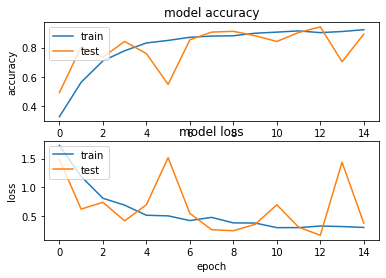

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss

plt.subplot(212) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

# Model testing

In [ ]:
# First, we are going to load the file names and their respective target labels into numpy array! 
from sklearn.datasets import load_files
import numpy as np

test_dir = 'test'

def load_dataset(path):
    data = load_files(path)
    # print(data)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])   # name of sub folders
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test, target_labels = load_dataset(test_dir)
# target_labels -> class name

In [ ]:
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [ ]:
from keras.utils import np_utils
y_test = np_utils.to_categorical(y_test,no_of_classes)

In [ ]:
# We just have the file names in the x set. Let's load the images and convert them into array.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (360, 200, 200, 3)


In [ ]:
x_test = x_test.astype('float32')/255

In [ ]:
# Let's visualize test prediction.
y_pred = model.predict(x_test)

In [ ]:
x_test.shape[0]

360

In [ ]:
correct_count = 0
for i in range(x_test.shape[0]):
    pred_idx = np.argmax(y_pred[i])
    true_idx = np.argmax(y_test[i])
    if pred_idx == true_idx:
        correct_count += 1

print("Test Accuracy:", correct_count/x_test.shape[0])

Test Accuracy: 0.8916666666666667


In [ ]:
y_pred

array([[1.0000000e+00, 6.1330529e-33, 1.5210992e-12, 1.6335720e-14,
        3.2591901e-11, 2.2231263e-18],
       [6.0878694e-01, 5.5461820e-05, 2.9346787e-03, 3.0718338e-01,
        6.2565476e-02, 1.8474080e-02],
       [2.1771310e-08, 9.8165256e-01, 1.5329954e-08, 1.9241647e-04,
        1.7312876e-03, 1.6423682e-02],
       ...,
       [1.2978996e-08, 9.8283929e-01, 1.8694852e-08, 3.1354153e-03,
        1.7477479e-04, 1.3850483e-02],
       [9.9998844e-01, 1.5080298e-24, 1.1530762e-05, 3.7136199e-09,
        2.6432917e-11, 2.1236216e-10],
       [6.1397551e-04, 1.8508937e-24, 9.9938595e-01, 4.9450721e-13,
        2.6211252e-08, 3.7582044e-13]], dtype=float32)

In [ ]:
y_test

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

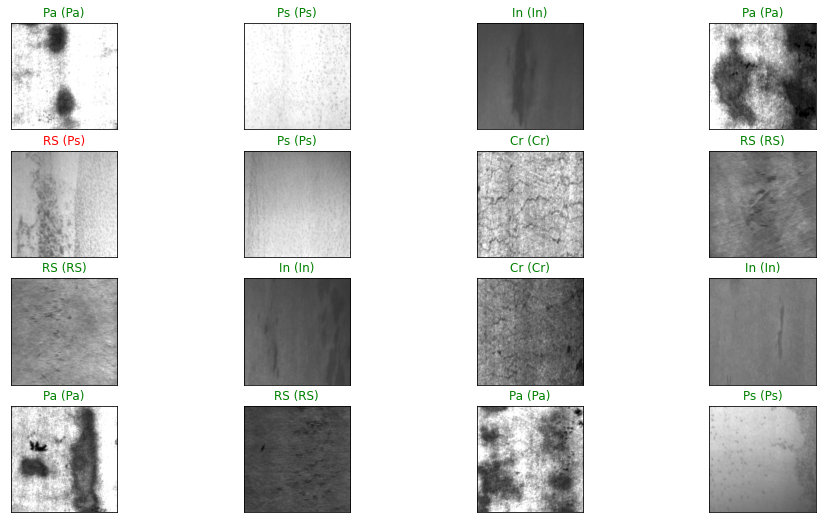

In [ ]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
# for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [1]:
pip install pycco

     |████████████████████████████████| 81kB 4.8MB/s 
  Created wheel for pystache: filename=pystache-0.5.4-cp36-none-any.whl size=82930 sha256=f48248c31a67dc9cd0b5f32d06bd44dff72e63f6723c7f12950eabc68a7a8f58
  Stored in directory: /root/.cache/pip/wheels/a6/e9/b0/a29a4f37e8f5a765473dd7936ef025d9d2543e07b55d88697c
Successfully built pystache


In [4]:
!pycco surface_defects_detection_v3.py

pycco: surface_defects_detection_v3.py -> docs/surface_defects_detection_v3.html
